In [1]:
#export
"""
fast_train.py
DO NOT EDIT THIS FILE! THIS FILE IS AUTO-GENERATED!
"""

'\nfast_train.py\nDO NOT EDIT THIS FILE! THIS FILE IS AUTO-GENERATED!\n'

In [122]:
import matplotlib.pyplot as plt
from graphpaper import GraphPaper

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [86]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## Data
- args: gpu
- pipeline: integer data -> binary data -> torch tensor -> ds -> dl -> wrapper

In [4]:
#export
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

In [5]:
import sys
PATH_TO_MODULES = '../modules'
sys.path.append(PATH_TO_MODULES)

In [6]:
#export
from data_utils import WrappedDataLoader

##### integer data -> binary data

In [7]:
int_data = np.ones((64, 16, 16), dtype=int)
binary_data = np.rollaxis(np.eye(17)[int_data], 3, 1)

In [8]:
np.unique(binary_data)

array([0., 1.])

In [9]:
binary_data.shape

(64, 17, 16, 16)

In [10]:
#export -class:DataConversion
def np_int2np_binary(np_int_data:np.array, num_channels:np.array)->np.array:
    """
    Convert 2d arrays of integers to 3d arrays of zeros and ones using one-hot encoding.
    
    :param np_int_data: an array of to-be-converted 2d arrays, shape: (bs, height, width)
    :param num_channels: the depth of the to-be-outputted 3d arrays
    :return an array of 3d arrays, shape: (bs, height, width, num_channels)
    """
    return np.rollaxis(np.eye(num_channels)[int_data], 3, 1)

In [11]:
assert np_int2np_binary(int_data, 17).tolist() == binary_data.tolist()

##### binary data -> ds

In [12]:
torch_tensor = torch.from_numpy(binary_data)

In [13]:
#export -class:DataConversion
def np_array2torch_tensor(np_array:np.array)->torch.Tensor:
    """Convert an NumPy array to a PyTorch tensor."""
    return torch.from_numpy(np_array)

In [14]:
assert torch.all(torch.eq(np_array2torch_tensor(binary_data), torch_tensor))

##### torch tensor -> ds -> dl -> wrapper (usually a one-step process)

In [15]:
#export -class:DataPreprocess
def to_cuda(xs:torch.Tensor, ys:torch.Tensor)->tuple:
    """Convert two PyTorch tensors to double-precision and put them on GPU."""
    assert torch.cuda.is_available(), AssertionError('Preprocessing function `to_cuda` only works when GPU is available.')
    return xs.double().to(torch.device('cuda')), ys.double().to(torch.device('cuda'))

In [16]:
#export -class:DataConversion
def get_dl(torch_xs:torch.Tensor, torch_ys:torch.Tensor, bs:int, shuffle:bool, preprocess_func=None)->WrappedDataLoader:
    """
    Convert two PyTorch tensors to a WrappedDataLoader.
    
    :param xs: a PyTorch tensor of training examples with the zeroth axis being the batch axis
    :param ys: a PyTorch tensor of training targets with the zeroth axis being the batch axis
    :param bs: batch size
    :param shuffle: whether training examples and targets are shuffled, True for training, False for validation
    :param preprocess_func: a function that inputs a batch of training examples and targets, do something with them,
        and outputs them
    :return a WrappedDataLoader instance that can be used directly for training
    """
    ds = TensorDataset(torch_xs, torch_ys)
    dl = DataLoader(ds, batch_size=bs, shuffle=shuffle)
    wrapped_dl = WrappedDataLoader(dl, preprocess_func)
    return wrapped_dl

##### pipeline

- all functions in the DataConversion category must include type in their names
- all functions in preprocess do not need to since they all input torch.Tensors

In [17]:
#export -class:DataPipeline
def binary_vae(np_int_imgs:np.array, bs:int, shuffle:bool=True):
    """
    Convert an array of 2d arrays of integers to a WrappedDataLoader that can be used to train a binary VAE.
    A binary VAE is a VAE that takes in and outputs one-hot encoded arrays.
    
    :param np_int_imgs: an array of 2d arrays of integers, shape: (bs, height, width)
    :param bs: batch_size
    :param shuffle: whether training examples and targets are shuffled, True for training, False for validation
    :return a WrappedDataLoader instance that can be used directly for training a binary VAE
    """
    np_binary_imgs = np_int2np_binary(np_int_imgs, num_channels=2)
    torch_binary_imgs = np_array2torch_tensor(np_binary_imgs)
    if torch.cuda.is_available():
        dl = get_dl(
            torch_xs=torch_binary_imgs, torch_ys=torch_binary_imgs, 
            bs=bs, shuffle=shuffle, 
            preprocess_func=to_cuda
        )
    else:
        dl = get_dl(
            torch_xs=torch_binary_imgs, torch_ys=torch_binary_imgs, 
            bs=bs, shuffle=shuffle, 
            preprocess_func=None
        )
    return dl

In [18]:
#export -class:DataPipeline
def float_vae(np_float_imgs:np.array, bs:int, shuffle:bool=True):
    torch_float_imgs = np_array2torch_tensor(np_float_imgs)
    if torch.cuda.is_available():
        dl = get_dl(
            torch_xs=torch_float_imgs, torch_ys=torch_float_imgs, 
            bs=bs, shuffle=shuffle, 
            preprocess_func=to_cuda
        )
    else:
        dl = get_dl(
            torch_xs=torch_float_imgs, torch_ys=torch_float_imgs, 
            bs=bs, shuffle=shuffle, 
            preprocess_func=None
        )
    return dl

In [19]:
binary_dl = binary_vae(int_data, bs=64, shuffle=True)

### Prepare mnist data using the functions I just wrote

In [20]:
from keras.datasets import mnist

Using TensorFlow backend.


In [21]:
def stats(array):
    print('shape: ', array.shape)
    print('max: ', array.max())
    print('min: ', array.min())
    print('std: ', array.std())
    print('mean: ', array.mean())

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=1)
stats(x_train)

x_train = (x_train - x_train.mean()) / x_train.std()
stats(x_train)

np.random.seed(42)
np.random.shuffle(x_train)
x_train = x_train[:10000]

shape:  (60000, 1, 28, 28)
max:  255
min:  0
std:  78.56748998339798
mean:  33.318421449829934
shape:  (60000, 1, 28, 28)
max:  2.821543345689335
min:  -0.424073894391566
std:  0.9999999999999998
mean:  -3.064638490070051e-17


In [23]:
float_dl = float_vae(x_train, bs=64, shuffle=True)

In [24]:
iter_dl = iter(float_dl)

In [25]:
xb, yb = next(iter_dl)
stats(xb)

shape:  torch.Size([64, 1, 28, 28])
max:  tensor(2.8215, dtype=torch.float64)
min:  tensor(-0.4241, dtype=torch.float64)
std:  tensor(0.9518, dtype=torch.float64)
mean:  tensor(-0.0412, dtype=torch.float64)


### This kinds of plot will serve as the basis for visualizing generated arrays during VAE training

In [93]:
paper = GraphPaper(height=4, width=10, nrows=2, ncols=5)

<Figure size 720x288 with 0 Axes>

In [94]:
for pos in range(1, 11, 1):
    paper.heatmap_2d(pos=pos, mat=xb[pos-1].squeeze().numpy(), ax_off='off')

`paper.show()` strangely doesn't work, but this shouldn't bother me too much because saving still works perfectly fine.

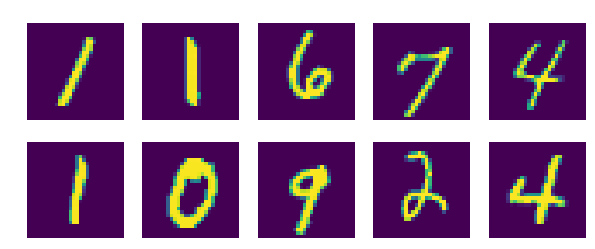

In [95]:
paper.fig

In [96]:
paper.save('10-mnist-digits.png', dpi=50)

Let's try to convert this matplotlib figure into a plotly figure, since dash only supports plotly. (Failed)

In [50]:
# from plotly.tools import mpl_to_plotly

In [51]:
# plotly can't yet import images from matplotlib
# mpl_to_plotly(paper.fig)

Let's try directly plotting the same 10 digits using plotly.

In [127]:
def plotly_10_digits(xb):
    
    NUM_ROWS = 2; NUM_COLS = 5

    fig = make_subplots(rows=NUM_ROWS, cols=NUM_COLS)

    for i in range(NUM_ROWS):
        for j in range(NUM_COLS):
            fig.add_trace(
                go.Heatmap(z=np.flipud(xb[i*NUM_COLS+j].squeeze().numpy())),
                row=i+1, col=j+1,
            )

    fig.update_layout(
        height=450, width=900, title_text="10 Generated Arrays", 
    )
    
    fig.show()

In [129]:
plotly_10_digits(xb)

## Model, optim
- args: gpu

In [97]:
#export
from model import get_model, load_model

In [140]:
vae, opt = get_model(dev='cpu', z_dim=64, nc=1)

## Loss

In [96]:
from torch.nn import functional as F

In [164]:
#export -class:Loss
def binary_loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / recon_x.size(0)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # already averaged over examples
    return BCE + KLD, BCE, KLD

In [275]:
#export -class:Loss
def float_loss_fn(recon_x, x, mu, logvar):
    BCE = torch.sum((recon_x - x) ** 2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

## Training loop, callbacks

In [147]:
#export
from graphpaper import GraphPaper
import pandas as pd

In [148]:
#export
class Learner():
    def __init__(self, train_data, model, loss, optim, valid_data=None):
        self.train_data, self.model, self.loss, self.optim, self.valid_data = train_data, model, loss, optim, valid_data

In [149]:
#export
class Callback(): 
    def on_train_begin(self, sd): pass
    def on_epoch_begin(self, sd): pass
    def on_batch_begin(self, sd): pass
    def on_loss_begin(self, sd): pass
    def on_backward_begin(self, sd): pass
    def on_backward_end(self, sd): pass
    def on_step_end(self, sd): pass
    def on_batch_end(self, sd): pass
    def on_epoch_end(self, sd): pass
    def on_train_end(self, sd): pass

In [150]:
#export
class MetricsRecorder(Callback):
    _order=1
    
    def on_train_begin(self, sd):
        sd['losses'], sd['bces'], sd['klds'] = [], [], []

    def on_epoch_begin(self, sd):
        self.total_loss, self.total_bce, self.total_kld = 0, 0, 0
        self.num_examples = 0
    
    def on_batch_end(self, sd):
        bs = sd.get('bs')
        loss_b = sd.get('loss_b')
        bce_b = sd.get('bce_b')
        kld_b = sd.get('kld_b')
        
        assert None not in (bs, loss_b, bce_b, kld_b), \
            AssertionError('One or more metric values are None.')
        
        self.num_examples += bs 
        self.total_loss += loss_b
        self.total_bce += bce_b
        self.total_kld += kld_b
    
    def on_epoch_end(self, sd):
        sd['losses'].append(self.total_loss / self.num_examples)
        sd['bces'].append(self.total_bce / self.num_examples)
        sd['klds'].append(self.total_kld / self.num_examples)

<IPython.core.display.Javascript object>


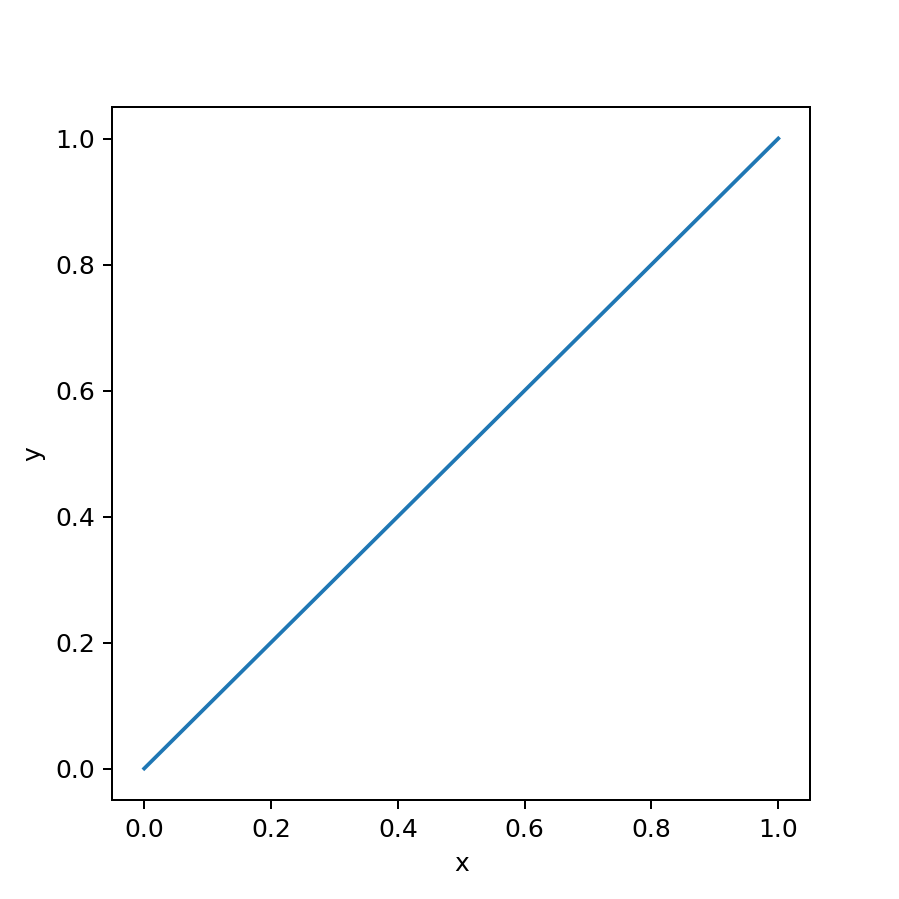

NameError: name 'axes' is not defined

In [102]:
paper = GraphPaper(height=5, width=5, nrows=1, ncols=1)
paper.plot_2d(pos=1, xs=[0, 1], ys=[0, 1], label='s')
paper.fig.delaxes(axes[1])
paper.plot_2d(pos=1, xs=[0, 1], ys=[1, 0], label='b')

In [103]:
#export
class MetricsPlotter(Callback):
    _order=2
    
    def __init__(self, png_name):
        self.paper = GraphPaper(height=5, width=7, nrows=1, ncols=1)
        self.png_name = png_name
    
    def on_epoch_end(self, sd):
        epochs = np.arange(1, sd['epoch']+1)
        
        if sd['epoch'] != 1: self.paper.fig.delaxes(self.paper.fig.axes[0])
        
        self.paper.plot_2d(
            pos=1, 
            xs=epochs, ys=sd['losses'], 
            label='LOSS',
            labels=('epochs', 'loss per example'), 
            grid=True,
        )

        self.paper.plot_2d(
            pos=1,
            xs=epochs, ys=sd['bces'],
            label='BCE',
            overlay=True
        )

        self.paper.plot_2d(
            pos=1,
            xs=epochs, ys=sd['klds'],
            label='KLD',
            overlay=True
        )
        
        self.paper.fig.legend()
        self.paper.fig.canvas.draw()
    
    def on_train_end(self, sd):
        self.paper.save(self.png_name)

In [104]:
#export
class MetricsLogger(Callback):
    _order=2
    
    def __init__(self, csv_name:str): self.csv_name = csv_name
    
    def on_train_end(self, sd):
        loss_df = pd.DataFrame(np.array([sd['losses'], sd['bces'], sd['klds']]).T)
        loss_df.columns = ['LOSS', 'BCE', 'KLD']
        loss_df.to_csv(self.csv_name)

In [105]:
#export
class ModelSaver(Callback):
    _order=2
    
    def __init__(self, model_name:str): self.model_name = model_name
    
    def on_train_end(self, sd):
        torch.save(sd['model'].state_dict(), self.model_name)

In [106]:
#export
class CallbackHandler(Callback): 
    
    def __call__(self, cb_category:str):
        for cb in self.cbs: getattr(cb, cb_category)(self.state_dict)
    
    def on_train_begin(self): self('on_train_begin')
        
    def on_epoch_begin(self): self('on_epoch_begin')
    
    def on_batch_begin(self): self('on_batch_begin')
        
    def on_loss_begin(self): self('on_loss_begin')
        
    def on_backward_begin(self): self('on_backward_begin')
        
    def on_backward_end(self): self('on_backward_end')
        
    def on_step_end(self): self('on_step_end')
        
    def on_batch_end(self): self('on_batch_end')
    
    def on_epoch_end(self): self('on_epoch_end')
        
    def on_train_end(self): self('on_train_end')

In [276]:
class VAETrainer(CallbackHandler):
    
    def __init__(self, learn, png_name, csv_name, model_name):
        self.learn = learn
        self.cbs = [MetricsRecorder(), MetricsPlotter(png_name), MetricsLogger(csv_name), ModelSaver(model_name)]
        self.cbs = sorted(self.cbs, key=lambda cb : cb._order)
        self.state_dict = {}
        
    def train(self, num_epochs):
        self.on_train_begin()  # create empty accumulators
        for epoch in range(num_epochs):
            self.on_epoch_begin()
            for xb, yb in log_progress(self.learn.train_data):
                
                self.on_batch_begin()
                
                recon, mu, logvar = self.learn.model(xb)
                
                self.on_loss_begin()
                loss, bce, kld = self.learn.loss(recon, yb, mu, logvar)
                
                self.on_backward_begin()
                loss.backward()
                self.on_backward_end()
                self.learn.optim.step()
                self.on_step_end()
                
                self.state_dict.update({
                    'model':self.learn.model, 'epoch':epoch+1, 'bs':int(xb.size(0)), 'loss_b':float(loss), 'bce_b':float(bce), 'kld_b':float(kld)
                })
                
                self.on_batch_end()
            self.on_epoch_end()  # calculate loss, do validation
        self.on_train_end()  # output a csv of metric values

In [277]:
import warnings
warnings.filterwarnings('ignore')

In [359]:
vae, opt = get_model(dev='cpu', z_dim=64, nc=2)
learn = Learner(train_data=binary_dl, model=vae, loss=binary_loss_fn, optim=opt)

In [279]:
vae, opt = get_model(dev='cpu', z_dim=64, nc=1)
learn = Learner(train_data=float_dl, model=vae, loss=float_loss_fn, optim=opt)

In [280]:
# speed is slower because network is bigger than a simple cnn

<IPython.core.display.Javascript object>


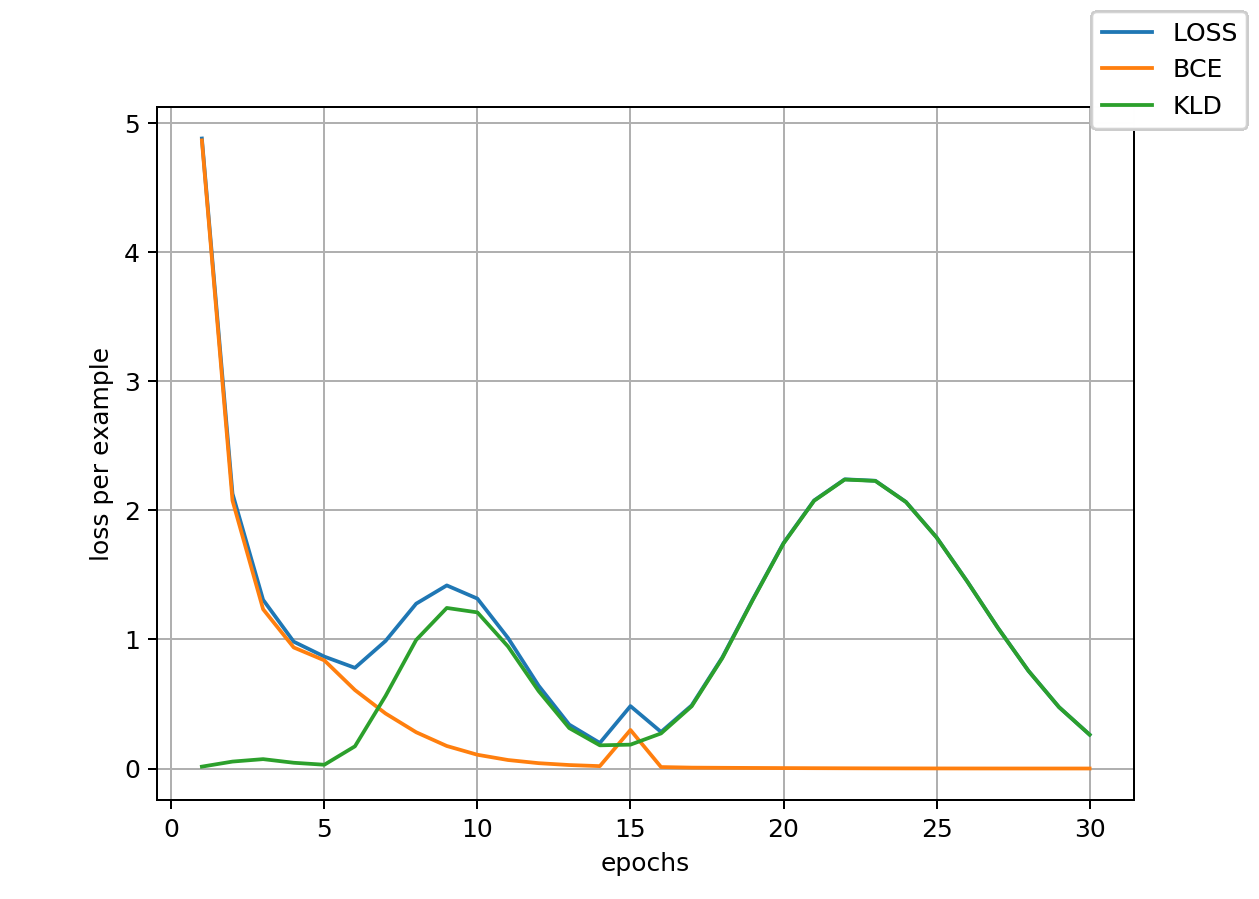

In [360]:
trainer = VAETrainer(learn, 'test.png', 'test.csv', 'test.pth')
trainer.train(30)

In [361]:
def decode_latent_vecs(vecs):
    vae = list(trainer.learn.model.children())[0]
    vae.eval()
    lin = list(trainer.learn.model.children())[0].fc3
    dec = list(trainer.learn.model.children())[0].decoder
    return dec(lin(vecs))

In [362]:
decoded_imgs = decode_latent_vecs(torch.randn(1, 64).double())

In [363]:
decoded_imgs.shape

torch.Size([1, 2, 16, 16])

In [366]:
np_decoded_imgs = decoded_imgs.detach()[0].squeeze().numpy().argmax(axis=0)

In [367]:
np_decoded_imgs.shape

(16, 16)

In [347]:
# first get the axes legend right, pass in individually rather than as a whole
# test using mnist data, don't use random data

In [348]:
import matplotlib.pyplot as plt

In [369]:
np_decoded_imgs

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

<IPython.core.display.Javascript object>


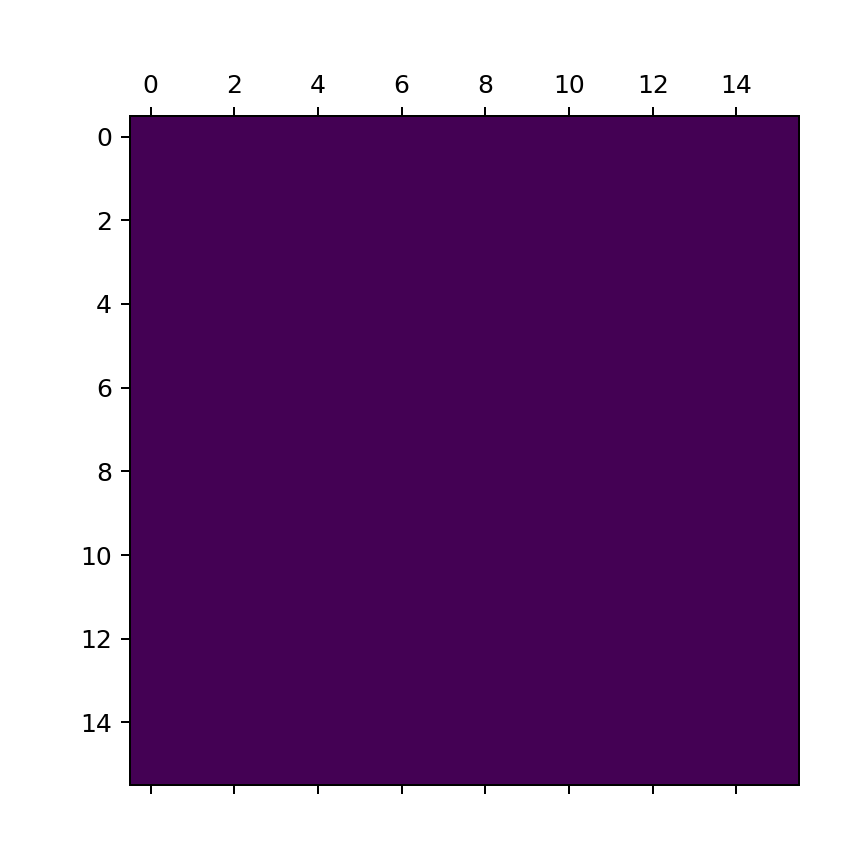

In [351]:
plt.matshow(np_decoded_imgs)

## Save model

In [309]:
plt.matshow?